# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating a textual description of an image. It combines Natural Language Processing (NLP) and Computer Vision to create captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation, which is then decoded into a descriptive text sequence.

**KANs + LSTMs**
- To perform Image Captioning, we utilize a combination of Kolmogorov-Arnold Networks (KANs) and Long Short-Term Memory (LSTM) networks.
- KANs: KANs are used in place of traditional CNNs to extract features from the image. These networks provide an alternative way to learn complex functions and mappings from images to feature vectors.
- LSTMs: LSTMs are employed for the text generation process. The image embeddings generated by the KANs are concatenated with the word embeddings and passed to the LSTM to generate the next word in the sequence.


<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

<img src="https://machinelearningmastery.com/wp-content/uploads/2017/09/Model-1-Generate-Whole-Sequence.png">

# Step 1: Import Necessary Libraries and Configure Settings

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, add, Reshape, concatenate, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import math
from PIL import Image

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2024-07-27 08:15:05.373624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 08:15:05.373686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 08:15:05.375513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 2: Load and Display Dataset

In [2]:
# Load Flickr8k dataset
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Step 3: Define Image Reading and Display Function

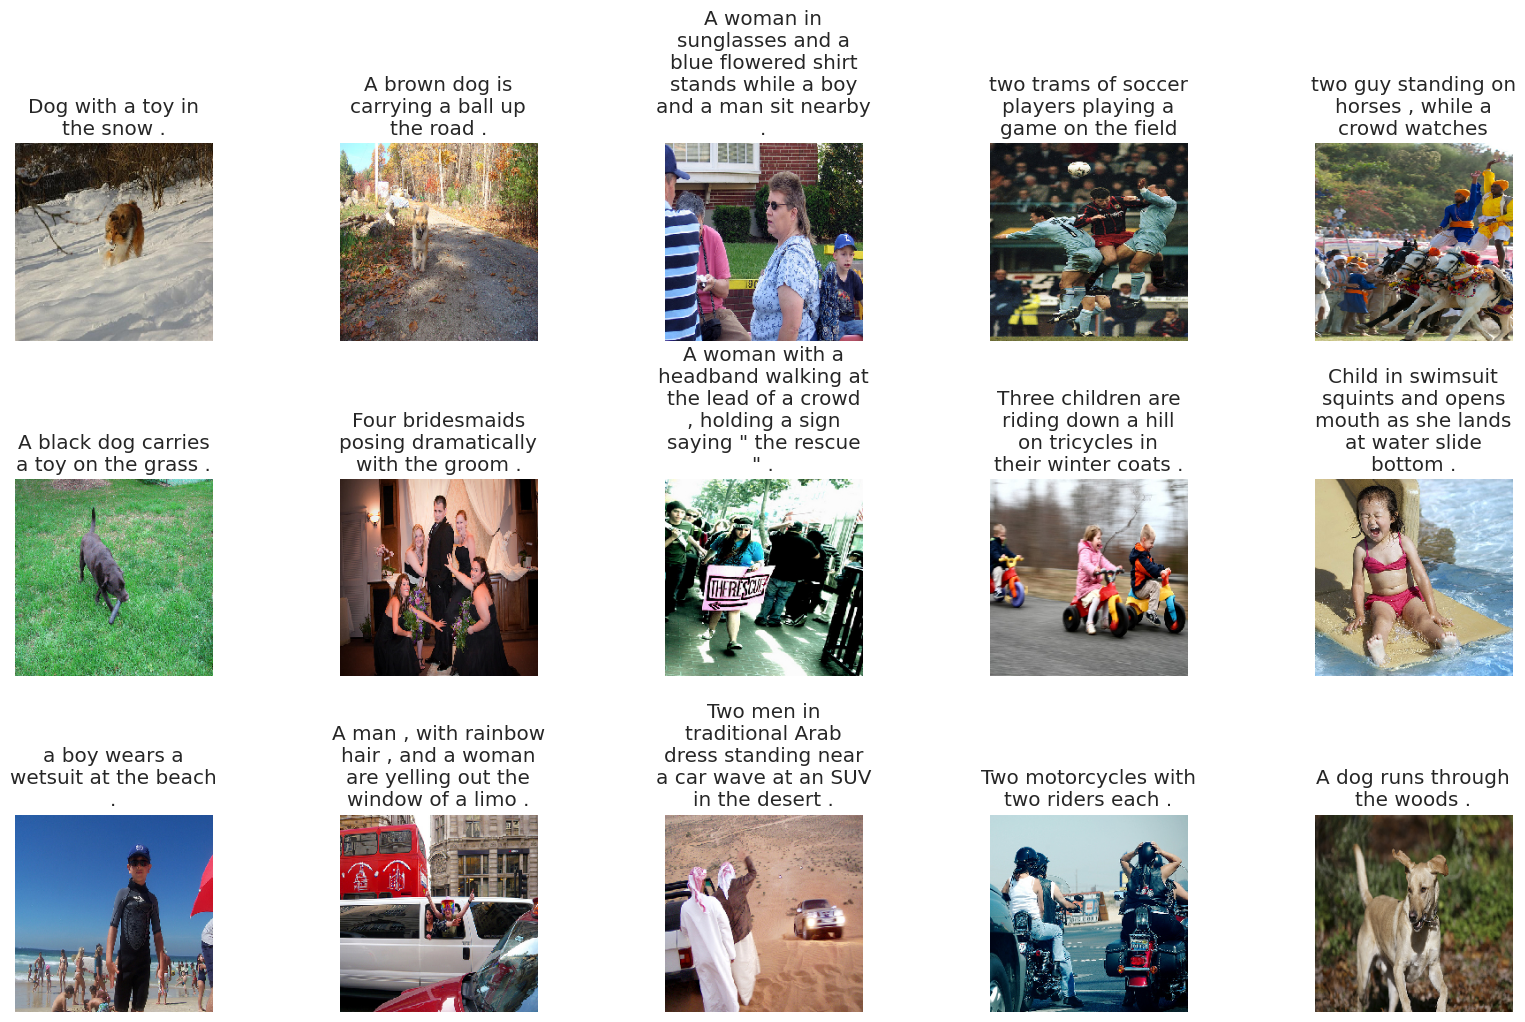

In [3]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"/kaggle/input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# Display some images with captions
display_images(data.sample(15))

# Step 4: Preprocess Captions

# **Caption Text Preprocessing Steps**
- Convert captions to strings
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [4]:
# Preprocess the captions
def text_preprocessing(data):
    data['caption'] = data['caption'].astype(str)
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()


# Step 5: Tokenize Captions

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [5]:
# Tokenize the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# Step 6: Split Data into Training and Validation Sets

In [6]:
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# Encoder: Image Feature Extraction
**Overview:**
The encoder is responsible for processing the input image and extracting features. We use a KANVGG16 model, which is a modified version of the VGG16 model incorporating Kolmogorov-Arnold Networks (KAN) layers. The encoder processes the image to extract high-level features that are fed into the decoder.




# Step 7: Define KANLinear


In [7]:
# KANLinear implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models

class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy


# VGG16:
**VGG16** is a convolutional neural network architecture that was introduced by the Visual Geometry Group (VGG) at the University of Oxford. It is known for its simplicity and depth, consisting of 16 layers including convolutional layers, fully connected layers, and max-pooling layers. VGG16 is widely used for image classification and feature extraction due to its strong performance on various benchmark datasets.

<img src='https://miro.medium.com/v2/resize:fit:1210/format:webp/1*97LotHRHWVBUsqimR0eieA.png'>

# Step 8: Define KANVGG16 Classes

In [8]:
class KANVGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(KANVGG16, self).__init__()
        vgg16 = models.vgg16_bn(pretrained=True)  # Load pretrained VGG16 with batch normalization
        self.features = vgg16.features

        self.classifier = nn.Sequential(
             KANLinear(512 * 7 * 7, 2048),
             nn.ReLU(inplace=True),
             nn.Dropout(0.4),
             KANLinear(2048, 2048),
             nn.ReLU(inplace=True),
             nn.Dropout(0.4),
             KANLinear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = KANVGG16().to(device)

# Step 9: Extract Features Using KANVGG16:

In [9]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load images and extract features
img_size = 224
features = {}

# Function to extract features from a single image
def extract_features(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model.features(image).cpu().numpy()
    return feature

for image in tqdm(os.listdir(image_path)):
    img_path = os.path.join(image_path, image)
    features[image] = extract_features(img_path, feature_extractor, transform)

# Save the extracted features for further use
np.save('image_features.npy', features)

100%|██████████| 8091/8091 [01:38<00:00, 82.18it/s]


# Decoder: Caption Decoding
**Overview:** The decoder is responsible for processing the input sequence (captions) and generating the output sequence (predicted words in the caption). This is achieved by using an embedding layer followed by a unidirectional LSTM and several dense layers.


# Step 10: Define Custom Data Generator
**Overview:**
The CustomDataGenerator class is responsible for generating batches of data for training and validation. It handles the loading of image features and the corresponding captions, ensuring they are prepared correctly for input into the neural network.

In [10]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
          X1, X2, y = list(), list(), list()
          images = batch[self.X_col].tolist()
          captions = batch[self.y_col].tolist()

          for img_name, caption in zip(images, captions):
              img_features = self.features.get(img_name)
              if img_features is None:
                  raise ValueError(f"Feature for image {img_name} not found")
              img_features = img_features.flatten()

              seq = self.tokenizer.texts_to_sequences([caption])[0]
              for i in range(1, len(seq)):
                  in_seq, out_seq = seq[:i], seq[i]
                  in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                  out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                  X1.append(img_features)  # Repeat the image feature for each sequence element
                  X2.append(in_seq)
                  y.append(out_seq)

          return np.array(X1), np.array(X2), np.array(y)

# Step 11: Define and Compile the Model

In [11]:
input1 = Input(shape=(512*7*7,))
input2 = Input(shape=(max_length,))

img_features = Dense(2048, activation='relu')(input1)
img_features = Reshape((1, 2048))(img_features)

sentence_features = Embedding(vocab_size, 2048, mask_zero=False)(input2)

merged = concatenate([img_features, sentence_features], axis=1)

sentence_features = LSTM(2048)(merged)
x = Dropout(0.4)(sentence_features)
x = add([x, Flatten()(img_features)])
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(vocab_size, activation='softmax')(x)
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

from tensorflow.keras.utils import plot_model

caption_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25088)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │ 51,382,272 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 2048)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 2048)  │ 17,377,280 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 2048)  │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 2048)      │ 33,562,624 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2048)      │          0 │ dropout[0][0],    │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  2,098,176 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  8,697,125 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,117,477 (431.51 MB)

 Trainable params: 113,117,477 (431.51 MB)

 Non-trainable params: 0 (0.00 B)

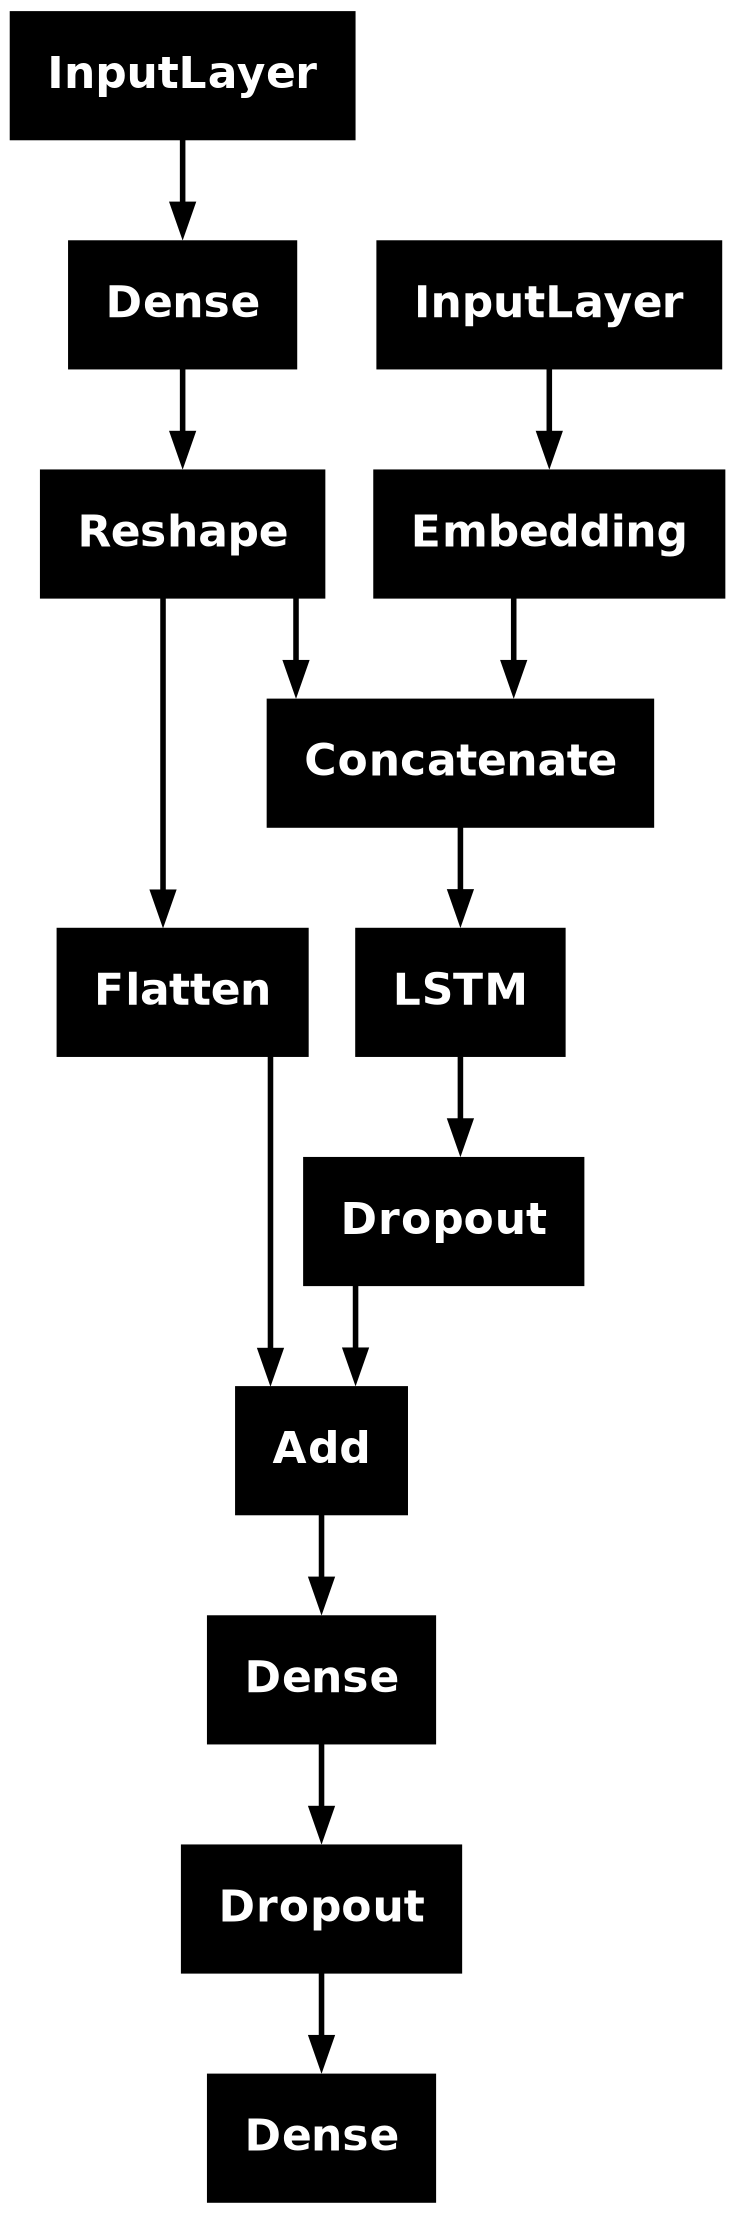

In [12]:
plot_model(caption_model)

# Step 12: Prepare Callbacks and Train the Model

In [13]:
train_features = np.load('image_features.npy', allow_pickle=True).item()
val_features = train_features  # Using the same features for validation as a placeholder

train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=128,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=train_features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=128,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=val_features)

model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.3, min_lr=0.000001)

In [14]:
!pip install rouge-score
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-1cvedjc0
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-1cvedjc0
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


In [15]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer, scoring
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.spice.spice import Spice

# Step 13: Define and Use Custom BLEU Callback:

   This is to generate metrics for each epoch.

In [16]:
# Custom BLEU callback with METEOR and SPICE
class BLEUCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, tokenizer, max_length, features):
        super().__init__()
        self.validation_data = validation_data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.features = features
        self.bleu_scores = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'BLEU-4': []}
        self.rouge_scores = {'ROUGE-1': [], 'ROUGE-2': [], 'ROUGE-L': []}
        self.cider_scores = []
        self.meteor_scores = []
        #self.spice_scores = []

    def idx_to_word(self, integer):
        for word, index in self.tokenizer.word_index.items():
            if index == integer:
                return word
        return None

    def predict_caption(self, image):
        feature = self.features[image].flatten()
        in_text = "startseq"
        for i in range(self.max_length):
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)
            preds = self.model.predict([np.array([feature]), sequence],verbose=0)[0]
            preds = np.asarray(preds).astype('float64')
            preds = np.log(preds + 1e-10) / 0.7  # Smoothing prediction with temperature
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            y_pred = np.argmax(probas)
            word = self.idx_to_word(y_pred)
            if word is None or word == 'endseq':
                break
            in_text += ' ' + word
        return in_text

    def compute_corpus_rouge_scores(self, references, predictions):
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        aggregator = scoring.BootstrapAggregator()

        for ref, pred in zip(references, predictions):
            score = scorer.score(ref, pred)
            aggregator.add_scores(score)

        result = aggregator.aggregate()
        rouge_1 = result['rouge1'].mid.fmeasure
        rouge_2 = result['rouge2'].mid.fmeasure
        rouge_l = result['rougeL'].mid.fmeasure
        return rouge_1, rouge_2, rouge_l

    def compute_corpus_cider_score(self, references, predictions):
        gts = {i: [ref] for i, ref in enumerate(references)}
        res = {i: [pred] for i, pred in enumerate(predictions)}
        cider_scorer = Cider()
        cider_score, _ = cider_scorer.compute_score(gts, res)
        return cider_score

    def compute_corpus_meteor_score(self, references, predictions):
        gts = {i: [ref] for i, ref in enumerate(references)}
        res = {i: [pred] for i, pred in enumerate(predictions)}
        meteor_scorer = Meteor()
        meteor_score, _ = meteor_scorer.compute_score(gts, res)
        return meteor_score

    def compute_corpus_spice_score(self, references, predictions):
        gts = {i: [ref] for i, ref in enumerate(references)}
        res = {i: [pred] for i, pred in enumerate(predictions)}
        spice_scorer = Spice()
        spice_score, _ = spice_scorer.compute_score(gts, res)
        return spice_score

    def on_epoch_end(self, epoch, logs=None):
        actual, predicted = [], []

        # Sample 15 images from the validation data
        sampled_validation_data = self.validation_data.sample(15).reset_index(drop=True)

        for index, record in sampled_validation_data.iterrows():
            generated_caption = self.predict_caption(record['image'])
            actual.append([record['caption'].split()])  # NLTK expects a list of lists for the actual
            predicted.append(generated_caption.split())

        # Calculate BLEU scores
        bleu_1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

        self.bleu_scores['BLEU-1'].append(bleu_1)
        self.bleu_scores['BLEU-2'].append(bleu_2)
        self.bleu_scores['BLEU-3'].append(bleu_3)
        self.bleu_scores['BLEU-4'].append(bleu_4)

        # Calculate ROUGE scores
        references = [" ".join(a[0]) for a in actual]
        predictions = [" ".join(p) for p in predicted]
        rouge_1, rouge_2, rouge_l = self.compute_corpus_rouge_scores(references, predictions)
        
        self.rouge_scores['ROUGE-1'].append(rouge_1)
        self.rouge_scores['ROUGE-2'].append(rouge_2)
        self.rouge_scores['ROUGE-L'].append(rouge_l)

        # Calculate CIDEr scores
        cider_score = self.compute_corpus_cider_score(references, predictions)
        self.cider_scores.append(cider_score)

        # Calculate METEOR scores
        meteor_score = self.compute_corpus_meteor_score(references, predictions)
        self.meteor_scores.append(meteor_score)

        # Calculate SPICE scores
        #spice_score = self.compute_corpus_spice_score(references, predictions)
        #self.spice_scores.append(spice_score)

        print(f"Epoch {epoch+1} - BLEU-1: {bleu_1:.4f}, BLEU-2: {bleu_2:.4f}, BLEU-3: {bleu_3:.4f}, BLEU-4: {bleu_4:.4f}")
        print(f"Epoch {epoch+1} - ROUGE-1: {rouge_1:.4f}, ROUGE-2: {rouge_2:.4f}, ROUGE-L: {rouge_l:.4f}")
        print(f"Epoch {epoch+1} - CIDEr: {cider_score:.4f}")
        print(f"Epoch {epoch+1} - METEOR: {meteor_score:.4f}")
        #print(f"Epoch {epoch+1} - SPICE: {spice_score:.4f}")


# Prepare the BLEU callback
bleu_callback = BLEUCallback(validation_data=test, tokenizer=tokenizer, max_length=max_length, features=val_features)

# Step 14: Train the Model with Custom BLEU Callback


In [17]:
# Train the model
history = caption_model.fit(train_generator, epochs=50, validation_data=validation_generator, 
                            callbacks=[checkpoint, earlystopping, learning_rate_reduction, bleu_callback])

Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.8319
Epoch 1: val_loss improved from inf to 4.21546, saving model to model.keras
Epoch 1 - BLEU-1: 0.2096, BLEU-2: 0.0636, BLEU-3: 0.1571, BLEU-4: 0.2404
Epoch 1 - ROUGE-1: 0.2344, ROUGE-2: 0.0219, ROUGE-L: 0.2226
Epoch 1 - CIDEr: 0.2094
Epoch 1 - METEOR: 0.0924
268/268 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - loss: 5.8290 - val_loss: 4.2155 - learning_rate: 0.0010
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.1171
Epoch 2: val_loss improved from 4.21546 to 3.87010, saving model to model.keras
Epoch 2 - BLEU-1: 0.1963, BLEU-2: 0.0793, BLEU-3: 0.0368, BLEU-4: 0.0794
Epoch 2 - ROUGE-1: 0.2229, ROUGE-2: 0.0381, ROUGE-L: 0.2247
Epoch 2 - CIDEr: 0.2043
Epoch 2 - METEOR: 0.1081
268/268 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - loss: 4.1167 - val_loss: 3.8701 - learning_rate: 0.0010
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.6252
Epoch 3: val_loss improved from 3.87010 to 3.75849, saving model to model.keras
Ep

# Step 15: Plot Training and Validation Loss

<Figure size 2000x800 with 0 Axes>

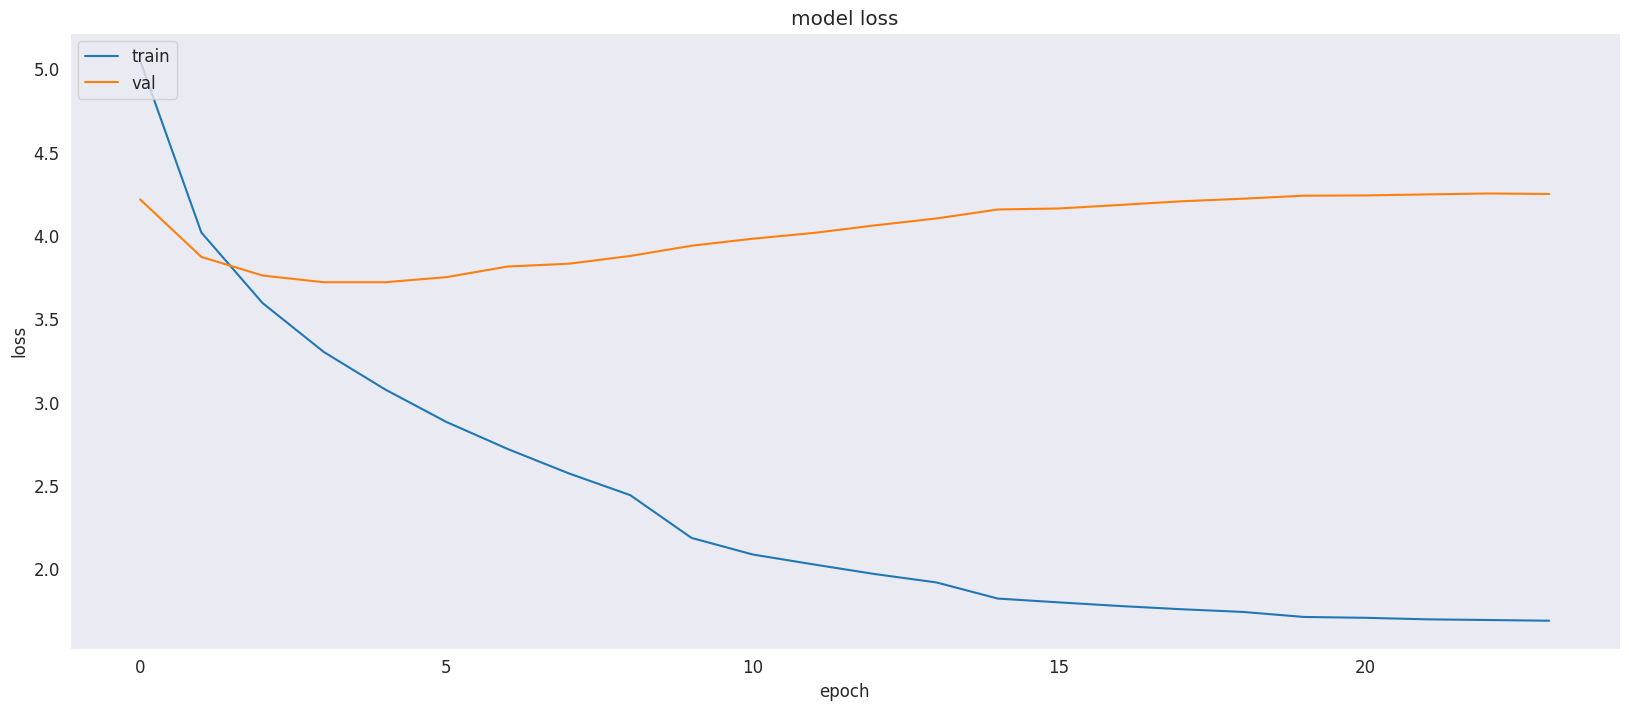

In [57]:
plt.figure(figsize=(20, 8))

plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# Step 16: Evaluate the Model and Display Results

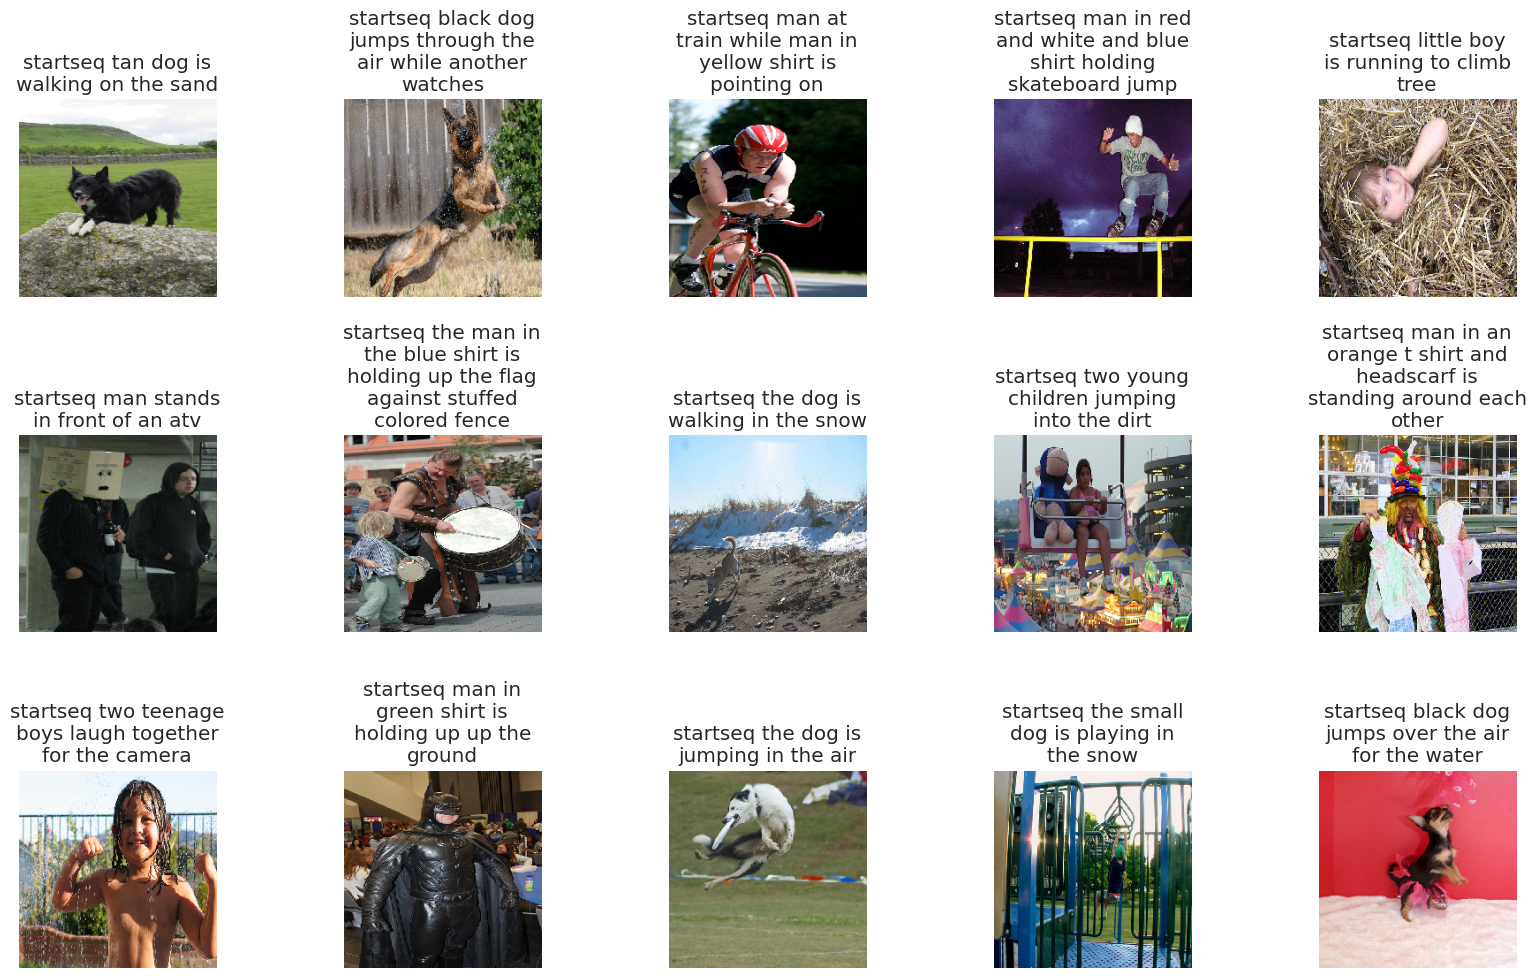

In [87]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features, temperature=0.6):
    feature = features[image].flatten()
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        preds = model.predict([np.array([feature]), sequence], verbose=0)[0]
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + 1e-10) / temperature  # Smoothing prediction with temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        y_pred = np.argmax(probas)
        word = idx_to_word(y_pred, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

# Example usage
sample_images = test.sample(15)
sample_images.reset_index(drop=True, inplace=True)
for index, record in sample_images.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, train_features, temperature=0.6)
    sample_images.loc[index, 'caption'] = caption
display_images(sample_images)

def compute_corpus_rouge_scores(references, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()

    for ref, pred in zip(references, predictions):
        score = scorer.score(ref, pred)
        aggregator.add_scores(score)

    result = aggregator.aggregate()
    rouge_1 = result['rouge1'].mid.fmeasure
    rouge_2 = result['rouge2'].mid.fmeasure
    rouge_l = result['rougeL'].mid.fmeasure
    return rouge_1, rouge_2, rouge_l

def compute_corpus_cider_score(references, predictions):
    gts = {i: [ref] for i, ref in enumerate(references)}
    res = {i: [pred] for i, pred in enumerate(predictions)}
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(gts, res)
    return cider_score

def compute_corpus_meteor_score(references, predictions):
    gts = {i: [ref] for i, ref in enumerate(references)}
    res = {i: [pred] for i, pred in enumerate(predictions)}
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(gts, res)
    return meteor_score

def compute_corpus_spice_score(references, predictions):
    gts = {i: [ref] for i, ref in enumerate(references)}
    res = {i: [pred] for i, pred in enumerate(predictions)}
    spice_scorer = Spice()
    spice_score, _ = spice_scorer.compute_score(gts, res)
    return spice_score


# Step 17: Predict Captions and Calculate Final Evaluation Metrics

Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 8.840 s


Parsing reference captions
Parsing test captions


SPICE evaluation took: 1.304 s
done


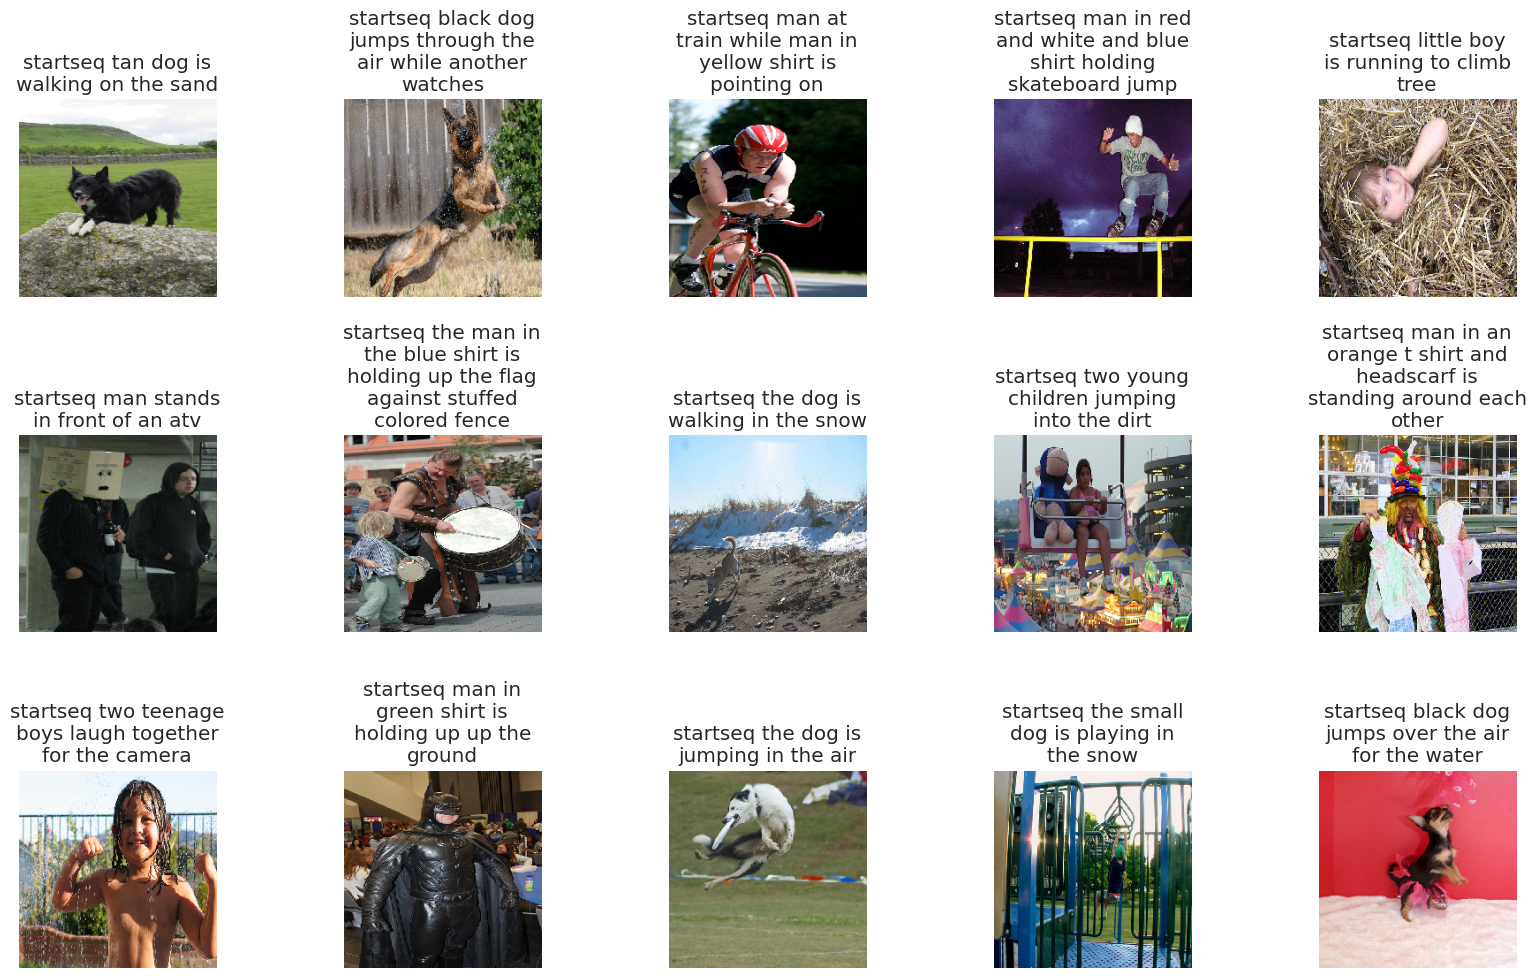

In [90]:
actual, predicted = [], []

for index, record in sample_images.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    generated_caption = predict_caption(caption_model, record['image'], tokenizer, max_length, train_features, temperature=0.6)
    
    # Store the actual and generated captions
    actual.append([record['caption'].split()])  # NLTK expects a list of lists for the actual
    predicted.append(generated_caption.split())
    
    # Update the DataFrame for displaying
    sample_images.loc[index, 'predicted_caption'] = generated_caption
    
display_images(sample_images)

# Display images with actual and predicted captions
    
references = [" ".join(a[0]) for a in actual]
predictions = [" ".join(p) for p in predicted]

rouge_1, rouge_2, rouge_l = compute_corpus_rouge_scores(references, predictions)
cider_score = compute_corpus_cider_score(references, predictions)
meteor_score = compute_corpus_meteor_score(references, predictions)
spice_score = compute_corpus_spice_score(references, predictions)

# Calculate final metrics
bleu_1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

rouge_1, rouge_2, rouge_l = compute_corpus_rouge_scores(references, predictions)

cider_score = compute_corpus_cider_score(references, predictions)
meteor_score = compute_corpus_meteor_score(references, predictions)
spice_score = compute_corpus_spice_score(references, predictions)
print("done")

Final BLEU-1: 0.4276
Final BLEU-2: 0.2737
Final BLEU-3: 0.1799
Final BLEU-4: 0.1116
------------------------------
Final ROUGE-1: 0.4521
Final ROUGE-2: 0.1956
Final ROUGE-L: 0.4405
------------------------------
Final CIDEr: 0.9776
Final METEOR: 0.1942
Final SPICE: 0.3114


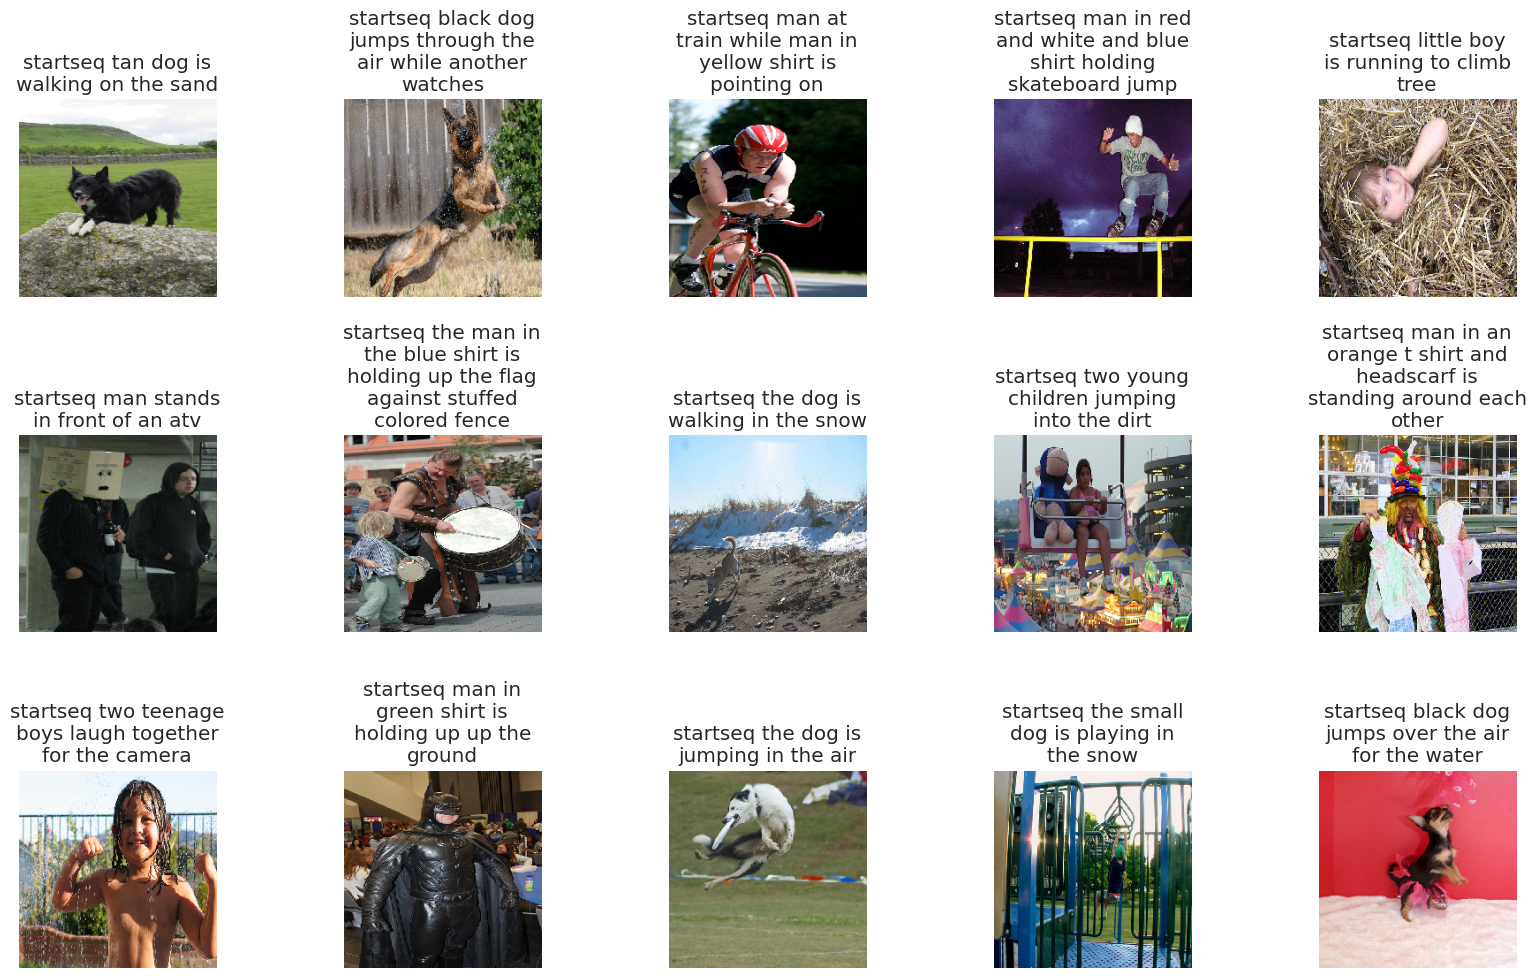

In [91]:
# Print BLEU scores
print(f"Final BLEU-1: {bleu_1:.4f}")
print(f"Final BLEU-2: {bleu_2:.4f}")
print(f"Final BLEU-3: {bleu_3:.4f}")
print(f"Final BLEU-4: {bleu_4:.4f}")

print("------------------------------")
print(f"Final ROUGE-1: {rouge_1:.4f}")
print(f"Final ROUGE-2: {rouge_2:.4f}")
print(f"Final ROUGE-L: {rouge_l:.4f}")
print("------------------------------")
print(f"Final CIDEr: {cider_score:.4f}")
print(f"Final METEOR: {meteor_score:.4f}")
print(f"Final SPICE: {spice_score:.4f}")

# Display images with actual and predicted captions
display_images(sample_images)

# Step 18: Plot Evaluation Metrics

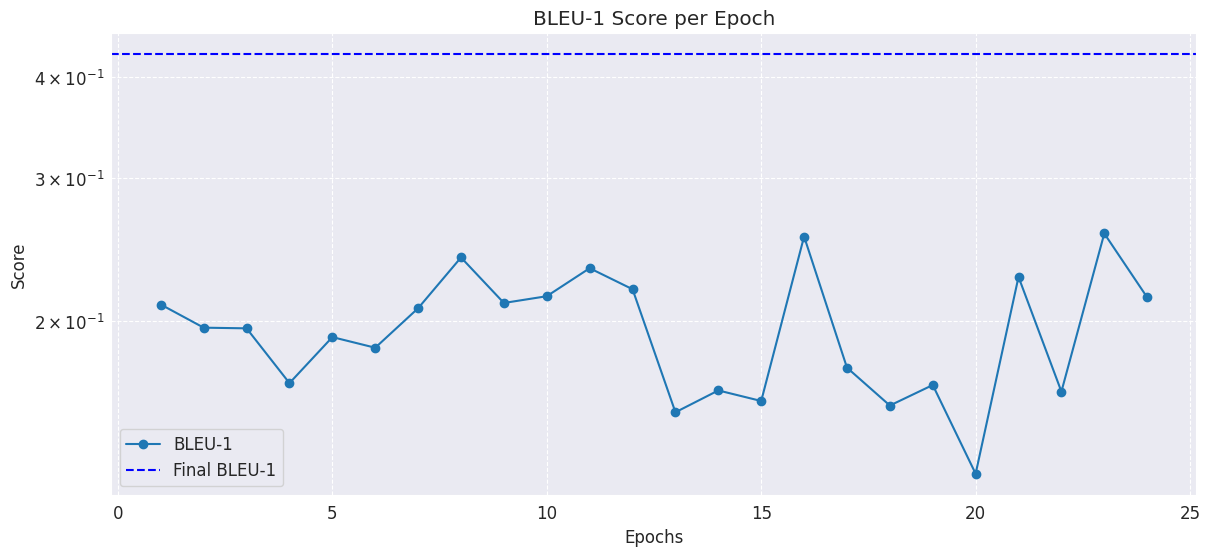

In [98]:
# Plot BLEU-1 scores and final BLEU-1 score

plt.figure(figsize=(14, 6))

# Plot BLEU-1 scores
plt.plot(range(1, len(bleu_callback.bleu_scores['BLEU-1']) + 1), bleu_callback.bleu_scores['BLEU-1'], marker='o', label='BLEU-1')

# Plot final BLEU-1 score
plt.axhline(y=bleu_1, color='blue', linestyle='--', label='Final BLEU-1')

plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('BLEU-1 Score per Epoch')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")

plt.show()


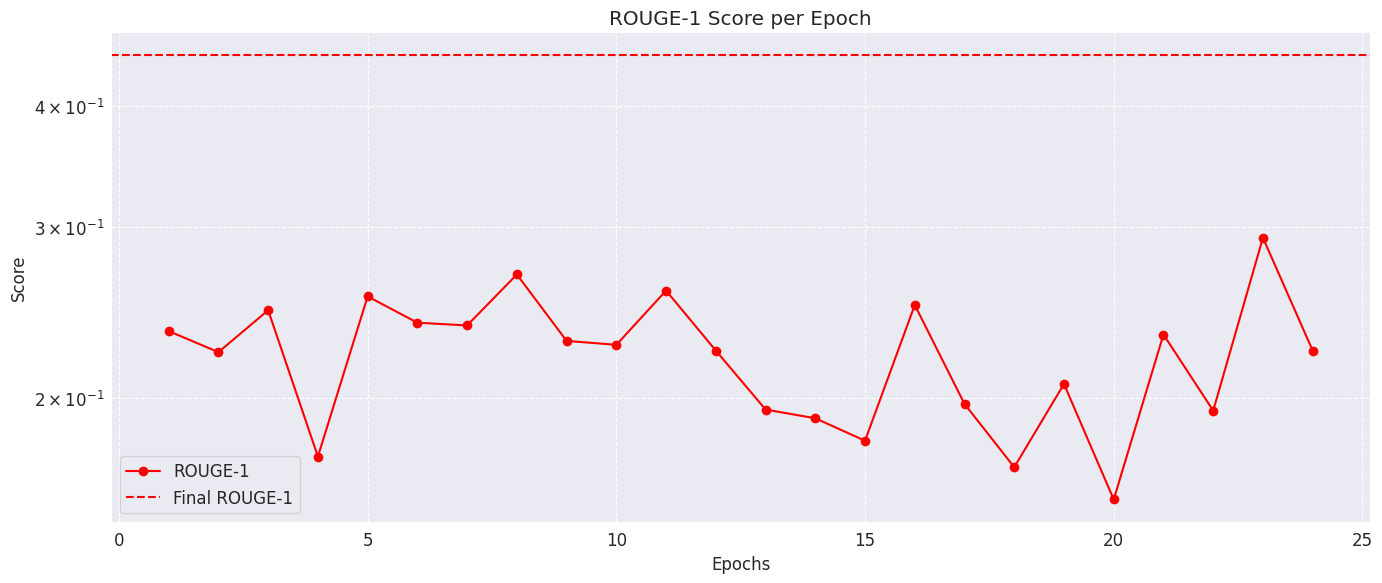

In [99]:
# Plot ROUGE-1 scores and final ROUGE-1 score
plt.figure(figsize=(14, 6))

# Plot ROUGE-1 scores
plt.plot(range(1, len(bleu_callback.rouge_scores['ROUGE-1']) + 1), bleu_callback.rouge_scores['ROUGE-1'], marker='o', color='red', label='ROUGE-1')
plt.axhline(y=rouge_1, color='red', linestyle='--', label='Final ROUGE-1')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('ROUGE-1 Score per Epoch')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


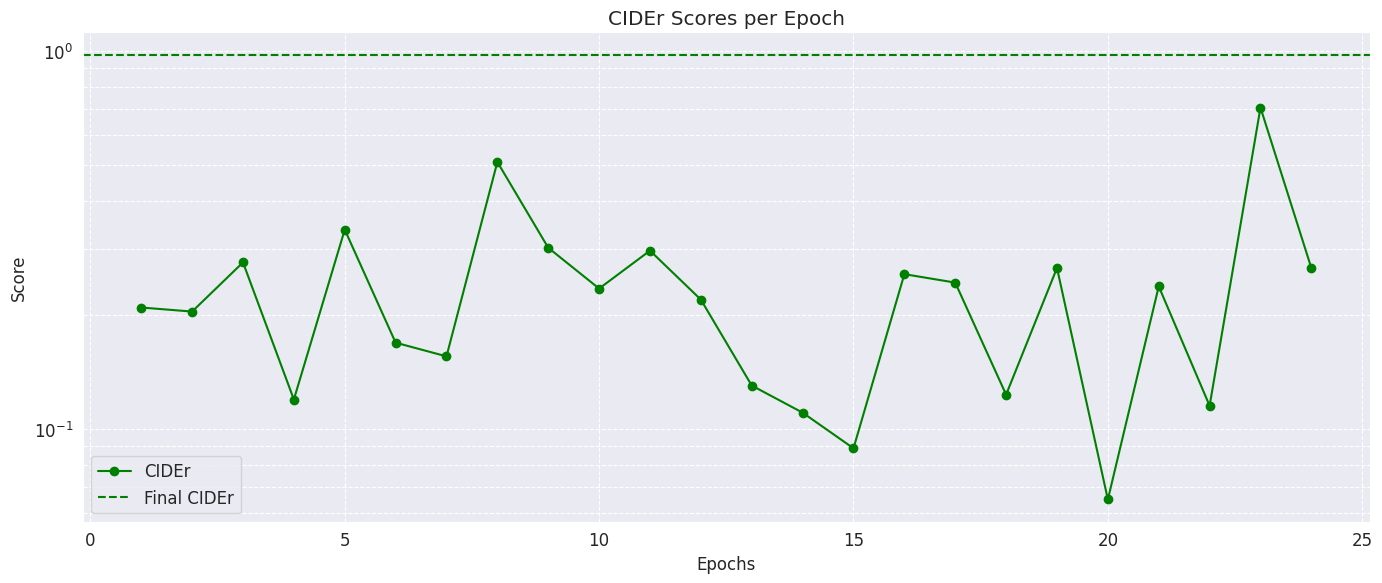

In [100]:
# Plot CIDEr scores and final CIDEr score
plt.figure(figsize=(14, 6))

# Plot CIDEr scores
plt.plot(range(1, len(bleu_callback.cider_scores) + 1), bleu_callback.cider_scores, marker='o', color='green', label='CIDEr')
plt.axhline(y=cider_score, color='green', linestyle='--', label='Final CIDEr')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('CIDEr Scores per Epoch')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


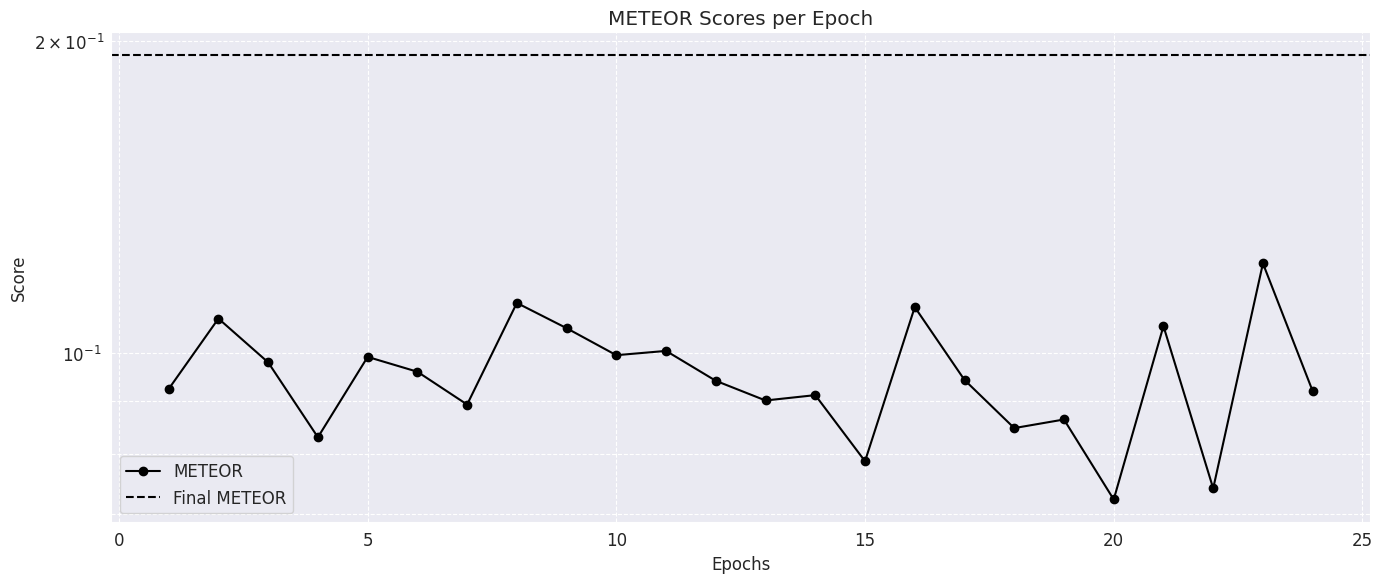

In [101]:
plt.figure(figsize=(14, 6))

# Plot METEOR scores
plt.subplot(1, 1, 1)
plt.plot(range(1, len(bleu_callback.meteor_scores) + 1), bleu_callback.meteor_scores, marker='o', color='black', label='METEOR')
plt.axhline(y=meteor_score, color='black', linestyle='--', label='Final METEOR')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('METEOR Scores per Epoch')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


In [26]:
'''
plt.figure(figsize=(14, 6))

# Plot SPICE scores
plt.plot(range(1, len(bleu_callback.spice_scores) + 1), bleu_callback.spice_scores, marker='o',color='orange', label='SPICE')
plt.axhline(y=spice_score, color='orange', linestyle='--', label='Final SPICE')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('SPICE Scores per Epoch')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()
'''

'\nplt.figure(figsize=(14, 6))\n\n# Plot SPICE scores\nplt.plot(range(1, len(bleu_callback.spice_scores) + 1), bleu_callback.spice_scores, marker=\'o\',color=\'orange\', label=\'SPICE\')\nplt.axhline(y=spice_score, color=\'orange\', linestyle=\'--\', label=\'Final SPICE\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Score\')\nplt.title(\'SPICE Scores per Epoch\')\nplt.legend()\nplt.yscale(\'log\')\nplt.grid(True, which="both", ls="--")\n\nplt.tight_layout()\nplt.show()\n'

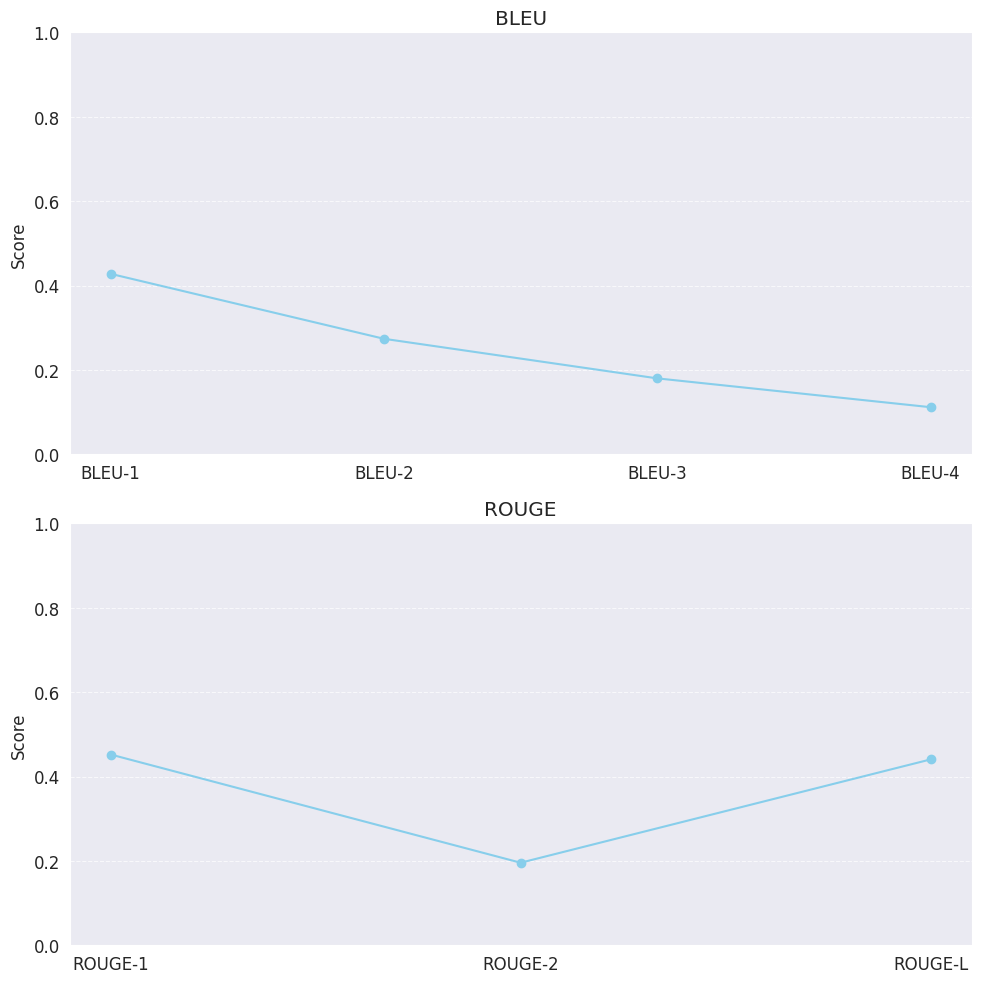

In [110]:
import matplotlib.pyplot as plt

# Create line plots for each metric
metrics = {
    'BLEU': [bleu_1, bleu_2, bleu_3, bleu_4],
    'ROUGE': [rouge_1, rouge_2, rouge_l],
}

# Labels for each metric's x-axis
metric_labels = {
    'BLEU': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'],
    'ROUGE': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
}

# Plot each metric in a separate subplot
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for ax, (metric_name, metric_values) in zip(axes, metrics.items()):
    ax.plot(metric_labels[metric_name], metric_values, marker='o', linestyle='-', color='skyblue')
    ax.set_ylabel('Score')
    ax.set_title(metric_name)
    ax.set_ylim(0, 1)  # assuming the scores are normalized between 0 and 1
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


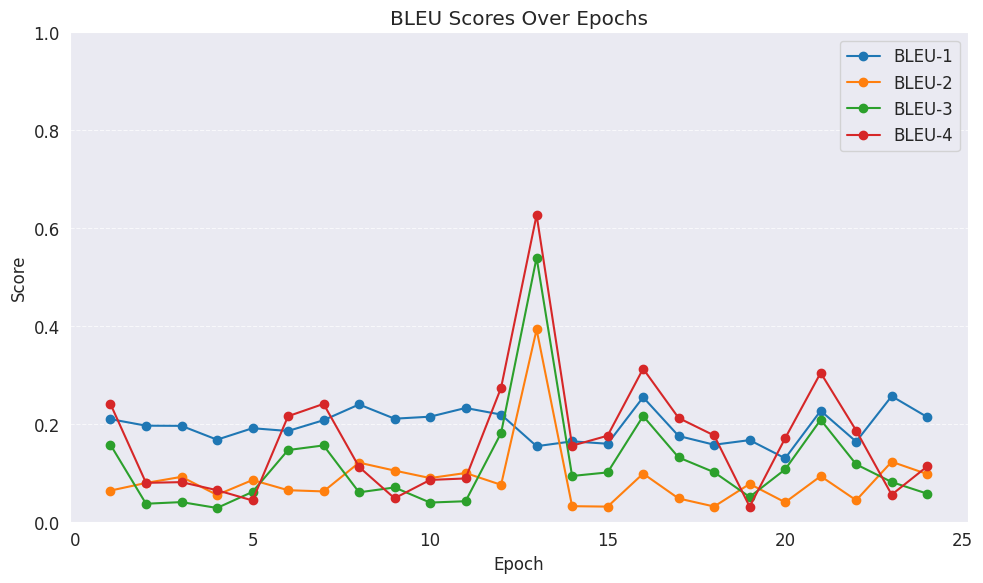

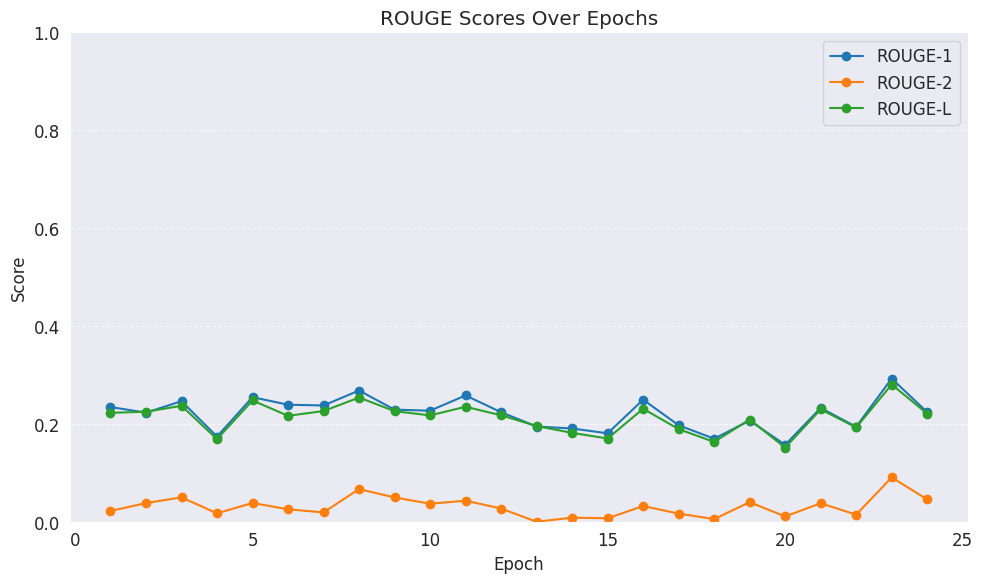

In [111]:
import matplotlib.pyplot as plt

# Plot BLEU scores
plt.figure(figsize=(10, 6))
for bleu_type in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']:
    plt.plot(range(1, len(bleu_callback.bleu_scores[bleu_type]) + 1), bleu_callback.bleu_scores[bleu_type], marker='o', label=bleu_type)
plt.title('BLEU Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot ROUGE scores
plt.figure(figsize=(10, 6))
for rouge_type in ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']:
    plt.plot(range(1, len(bleu_callback.rouge_scores[rouge_type]) + 1), bleu_callback.rouge_scores[rouge_type], marker='o', label=rouge_type)
plt.title('ROUGE Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


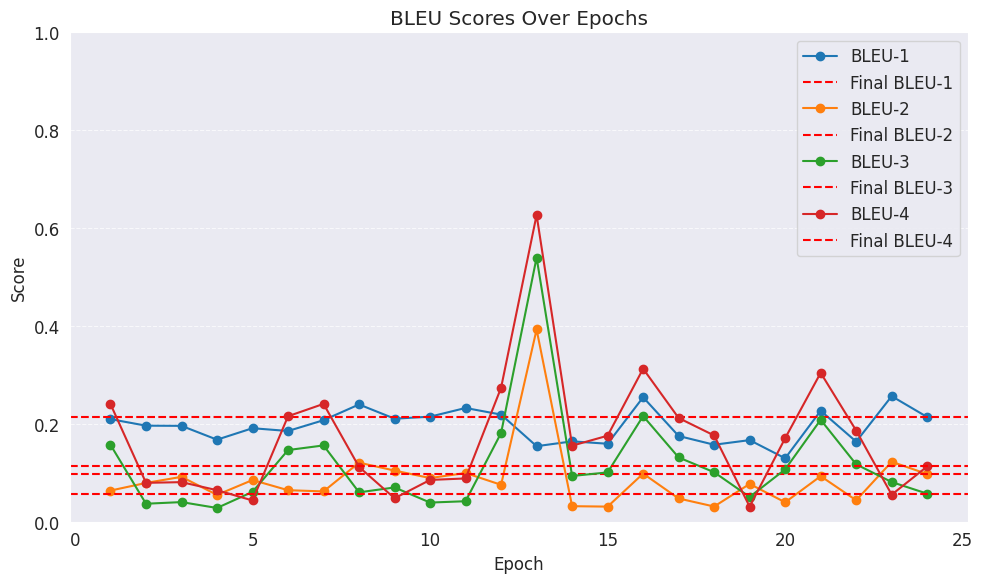

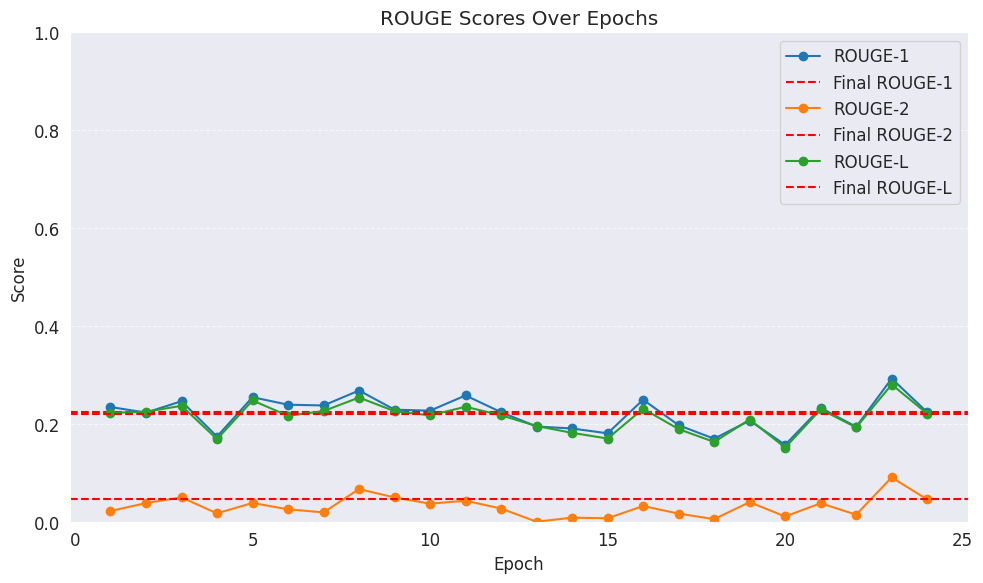

In [109]:
import matplotlib.pyplot as plt

# Get final BLEU scores
final_epoch = len(bleu_callback.bleu_scores['BLEU-1']) - 1
final_bleu_scores = {
    'BLEU-1': bleu_callback.bleu_scores['BLEU-1'][final_epoch],
    'BLEU-2': bleu_callback.bleu_scores['BLEU-2'][final_epoch],
    'BLEU-3': bleu_callback.bleu_scores['BLEU-3'][final_epoch],
    'BLEU-4': bleu_callback.bleu_scores['BLEU-4'][final_epoch]
}

# Plot BLEU scores
plt.figure(figsize=(10, 6))
for bleu_type in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']:
    plt.plot(range(1, len(bleu_callback.bleu_scores[bleu_type]) + 1), bleu_callback.bleu_scores[bleu_type], marker='o', label=bleu_type)
    plt.axhline(y=final_bleu_scores[bleu_type], color='r', linestyle='--', label=f'Final {bleu_type}')
plt.title('BLEU Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Get final ROUGE scores
final_rouge_scores = {
    'ROUGE-1': bleu_callback.rouge_scores['ROUGE-1'][final_epoch],
    'ROUGE-2': bleu_callback.rouge_scores['ROUGE-2'][final_epoch],
    'ROUGE-L': bleu_callback.rouge_scores['ROUGE-L'][final_epoch]
}

# Plot ROUGE scores
plt.figure(figsize=(10, 6))
for rouge_type in ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']:
    plt.plot(range(1, len(bleu_callback.rouge_scores[rouge_type]) + 1), bleu_callback.rouge_scores[rouge_type], marker='o', label=rouge_type)
    plt.axhline(y=final_rouge_scores[rouge_type], color='r', linestyle='--', label=f'Final {rouge_type}')
plt.title('ROUGE Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


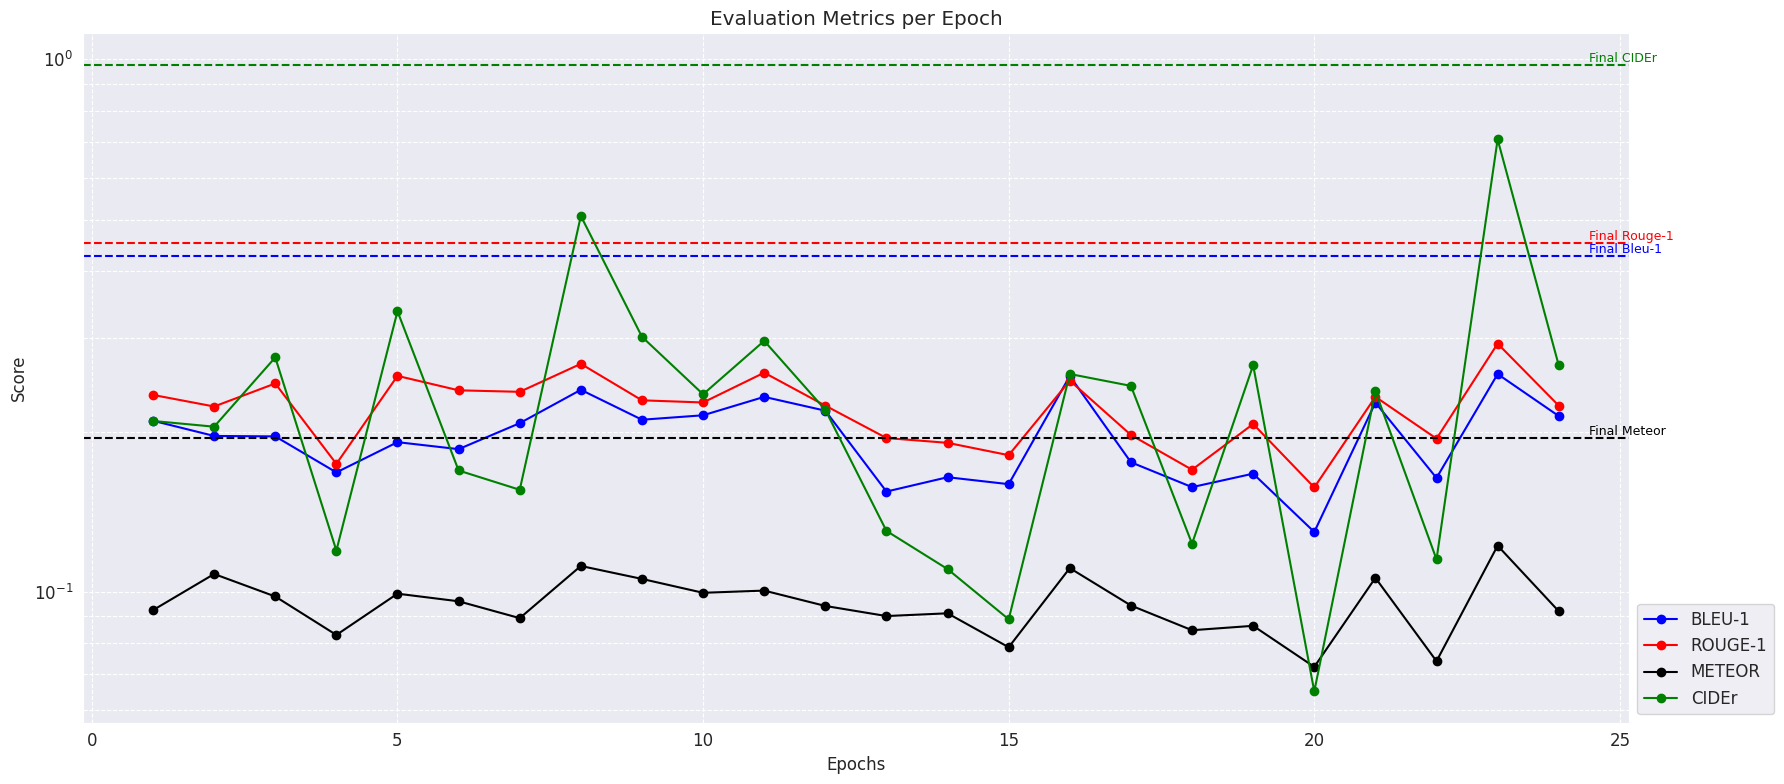

In [102]:
# Plot multiple metrics on the same graph
plt.figure(figsize=(18, 8))

# Plot BLEU-1 scores
plt.plot(range(1, len(bleu_callback.bleu_scores['BLEU-1']) + 1), bleu_callback.bleu_scores['BLEU-1'], marker='o', color='blue', label='BLEU-1')
plt.axhline(y=bleu_1, color='blue', linestyle='--')
plt.text(len(bleu_callback.bleu_scores['BLEU-1']) + 0.5, bleu_1, 'Final Bleu-1', color='blue', fontsize=9, verticalalignment='bottom')

# Plot ROUGE-1 scores
plt.plot(range(1, len(bleu_callback.rouge_scores['ROUGE-1']) + 1), bleu_callback.rouge_scores['ROUGE-1'], marker='o', color='red', label='ROUGE-1')
plt.axhline(y=rouge_1, color='red', linestyle='--')
plt.text(len(bleu_callback.rouge_scores['ROUGE-1']) + 0.5, rouge_1, 'Final Rouge-1', color='red', fontsize=9, verticalalignment='bottom')

# Plot METEOR scores
plt.plot(range(1, len(bleu_callback.meteor_scores) + 1), bleu_callback.meteor_scores, marker='o', color='black', label='METEOR')
plt.axhline(y=meteor_score, color='black', linestyle='--')
plt.text(len(bleu_callback.meteor_scores) + 0.5, meteor_score, 'Final Meteor', color='black', fontsize=9, verticalalignment='bottom')

# Plot CIDEr scores
plt.plot(range(1, len(bleu_callback.cider_scores) + 1), bleu_callback.cider_scores, marker='o', color='green', label='CIDEr')
plt.axhline(y=cider_score, color='green', linestyle='--')
plt.text(len(bleu_callback.cider_scores) + 0.5, cider_score, 'Final CIDEr', color='green', fontsize=9, verticalalignment='bottom')
'''
# Plot SPICE scores
plt.plot(range(1, len(bleu_callback.spice_scores) + 1), bleu_callback.spice_scores, marker='o', color='orange', label='SPICE')
plt.axhline(y=spice_score, color='orange', linestyle='--')
plt.text(len(bleu_callback.spice_scores) + 0.5, spice_score, 'Final Spice', color='orange', fontsize=9, verticalalignment='bottom')
'''
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Evaluation Metrics per Epoch')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.yscale('log')
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


# Results
**Observations:**The model has demonstrated an ability to generate meaningful captions for images. However, some redundancy and inaccuracies are still observed.
For example:

- **Redundancy:** There are instances where the model generates repetitive phrases such as "dog running through the water" even when the context might slightly differ.

- **Color Misidentification:** The model often incorrectly identifies colors in clothing, overusing terms like "blue shirt" for clothing items of different colors. Also it finds it hard to differentiate between dark colors and predicts the wrong captions for black or very dark backgrounds.

**Areas for Improvement:**

- Training Data: The model's performance could be significantly enhanced by training on a larger and more diverse dataset. More data would provide the model with a broader context and reduce overfitting to specific phrases or colors.

- Kolmogorov-Arnold Networks (KANs): While KANs have been effective in enhancing the model, further experimentation with different KAN configurations could yield better results.

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning with KANs perform compared to a similar Image Captioning without KANs. In the future as we explore KANs more, results of the model will improve.</p>